# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [27]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, \
    IDF, StringIndexer, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, StringType, FloatType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.sql.functions import udf
from pyspark.sql.functions import desc, asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import concat, lit, avg, split, isnan, isnull, when, count, col, \
sum, mean, stddev, min, max, countDistinct,approx_count_distinct, size, collect_set, round
from pyspark.sql import Window


import seaborn as sns
import re
from datetime import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, OneHotEncoderEstimator
from pyspark.ml.classification import  RandomForestClassifier, LogisticRegression, LinearSVC, NaiveBayes, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

In [28]:
# create a Spark session
spark = SparkSession\
    .builder\
    .appName("SmallSparkify")\
    .getOrCreate()

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [29]:
def drawline():
    print("***"*25)
df = spark.read.options(header=True).json("mini_sparkify_event_data.json")
df_pd = df.toPandas()  
df_pd.head()
    

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [30]:
df_pd.userAgent.unique()

array(['Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0',
       '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"',
       'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0',
       None,
       'Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20100101 Firefox/31.0',
       'Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0',
       '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
       '"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS 

In [31]:
print("number of rows:",df_pd.shape[0])
drawline()
print("number of null")
print(df_pd.isna().sum())

number of rows: 286500
***************************************************************************
number of null
artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64


Some of features have the same number of null value.

- Case 1. 58392: `artist`, `length`, `song`
- Case 2. 8346: `firstName`, `gender`, `lastName`, `location`, `registration`, `userAgent`
- Case 3. Full: `auth`, `itemInSession`, `level`, `method`, `page`, `sessionId`, `status`, `ts`, `userId`

Case 1 relates with the products of sparkify such as artists, songs, their length. The group of rows in Case 2 relates with user information. In any situation, the features in Case 3 always have some values. It is natural to find any **intersection** between Case 1 and 2.

In [32]:
df_pd.groupby("artist")['auth'].count().sort_values(ascending=False)

artist
Kings Of Leon                                                                                                                                                                                                                   1841
Coldplay                                                                                                                                                                                                                        1813
Florence + The Machine                                                                                                                                                                                                          1236
Dwight Yoakam                                                                                                                                                                                                                   1135
BjÃÂ¶rk                                                                     

In [33]:
tmp_artist_null_list = df_pd[df_pd.artist.isna()].index.tolist()
df_pd.iloc[tmp_artist_null_list,:].head(4)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
11,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
14,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
35,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54


In [34]:
df_pd['ts'] = df_pd['ts'].apply(lambda x: x/1000)
df_pd['ts'] =  pd.to_datetime(df_pd['ts'],  unit='s')

`artist` and `song` features have None not NaN. All None in the features is going to be replaced for my convenience.

In [35]:
# Change different representations such as None, empty cell to one representation `np.nan`
df_pd.replace(to_replace=[None], value=np.nan, inplace=True)
df_pd.replace(to_replace=[''], value=np.nan, inplace=True)

print("Number of rows that artist feature has Nan value: ", df_pd.iloc[tmp_artist_null_list,:].shape[0]); drawline()
tmp_artist__firstName_null_list = df_pd[(df_pd.artist.isna()) & (df_pd.firstName.isna())].index.tolist()
df_pd.iloc[tmp_artist__firstName_null_list,:].head(2)
print("Number of rows that artist and firstName features have Nan values: ",df_pd.iloc[tmp_artist__firstName_null_list,:].shape[0]); drawline()

Number of rows that artist feature has Nan value:  58392
***************************************************************************
Number of rows that artist and firstName features have Nan values:  8346
***************************************************************************


It is sure that  `Case 2` $\subset$ `Case 1` $\subset$ `Case 3`. Case 2 is special case of Case 1.

['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']


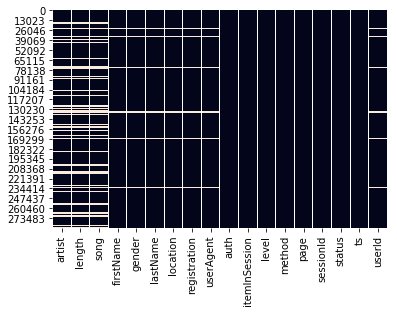

In [36]:
tmp_column_list = df_pd.columns.tolist()
print(tmp_column_list)
tmp_column_reorder_list = ['artist', 'length', 'song', 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent', 'auth',
                           'itemInSession', 'level', 'method', 'page', 'sessionId', 'status', 'ts', 'userId']

df_pd = df_pd[tmp_column_reorder_list]
plt.figure(figsize=(6, 4))
sns.heatmap(df_pd.isnull(), cbar=False)

It is found that userId feature actually has some null values. So each case has to be modified like below.

- Case 1. 58392: `artist`, `length`, `song`
- Case 2. 8346: `firstName`, `gender`, `lastName`, `location`, `registration`, `userAgent`,`userId`
- Case 3. Full: `auth`, `itemInSession`, `level`, `method`, `page`, `sessionId`, `status`, `ts`

['artist', 'length', 'song', 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent', 'auth', 'itemInSession', 'level', 'method', 'page', 'sessionId', 'status', 'ts', 'userId']


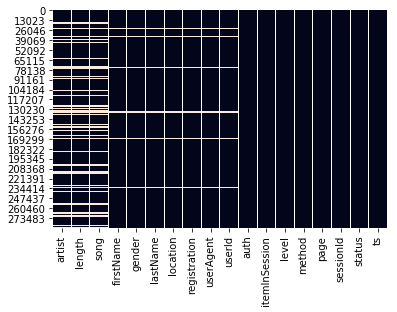

In [37]:
tmp_column_list = df_pd.columns.tolist()
print(tmp_column_list)
tmp_column_reorder_list = ['artist', 'length', 'song', 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent', 'userId',
                           'auth', 'itemInSession', 'level', 'method', 'page', 'sessionId', 'status', 'ts']

df_pd = df_pd[tmp_column_reorder_list]
plt.figure(figsize=(6, 4))
sns.heatmap(df_pd.isnull(), cbar=False)

### Check Case 2 for getting some insight

In [38]:
# Make dataframe of Case 2
pd.options.display.width = 0
df_case2 = df_pd.iloc[tmp_artist__firstName_null_list,:]

print("Unique values of auth: ", df_case2.auth.unique()); drawline()
print("Unique values of level: ", df_case2.level.unique()); drawline()
print("Unique values of method: ", df_case2.method.unique()); drawline()
print("Unique values of page: ", df_case2.page.unique()); drawline()
print("Unique values of status: ", df_case2.status.unique()); drawline()
print("Unique values of userId: ", df_case2.userId.unique()); drawline()

df_case2.head()

Unique values of auth:  ['Logged Out' 'Guest']
***************************************************************************
Unique values of level:  ['free' 'paid']
***************************************************************************
Unique values of method:  ['GET' 'PUT']
***************************************************************************
Unique values of page:  ['Home' 'Help' 'Login' 'About' 'Error' 'Register' 'Submit Registration']
***************************************************************************
Unique values of status:  [200 307 404]
***************************************************************************
Unique values of userId:  [nan]
***************************************************************************


,artist,length,song,firstName,gender,lastName,location,registration,userAgent,userId,auth,itemInSession,level,method,page,sessionId,status,ts
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logged Out,100,free,GET,Home,8,200,2018-10-01 01:02:25
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logged Out,101,free,GET,Help,8,200,2018-10-01 01:03:27
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logged Out,102,free,GET,Home,8,200,2018-10-01 01:04:01
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logged Out,103,free,PUT,Login,8,307,2018-10-01 01:04:02
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logged Out,2,free,GET,Home,240,200,2018-10-01 01:17:58


It seems that `status` means the list of HTTP status codes. 200 is OK, 307 is Temporary Redirect (since HTTP/1.1), and 404 is Not Found.

`method` means  HTTP methods like "GET", "PUT".

It seems like sparkify track logged out user by `sessionId`.

In [39]:
print(df_case2["auth"].value_counts()); drawline()
print(df_case2[df_case2["auth"]=="Guest"].level.unique()); drawline()
print(df_case2[df_case2["auth"]=="Logged Out"].level.unique()); drawline()
df_case2[df_case2["auth"]=="Logged Out"].head()

Logged Out    8249
Guest           97
Name: auth, dtype: int64
***************************************************************************
['free']
***************************************************************************
['free' 'paid']
***************************************************************************


,artist,length,song,firstName,gender,lastName,location,registration,userAgent,userId,auth,itemInSession,level,method,page,sessionId,status,ts
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logged Out,100,free,GET,Home,8,200,2018-10-01 01:02:25
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logged Out,101,free,GET,Help,8,200,2018-10-01 01:03:27
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logged Out,102,free,GET,Home,8,200,2018-10-01 01:04:01
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logged Out,103,free,PUT,Login,8,307,2018-10-01 01:04:02
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logged Out,2,free,GET,Home,240,200,2018-10-01 01:17:58


Because unique values of `page` in Case 2 are 'Home' 'Help' 'Login' 'About' 'Error' 'Register' 'Submit Registration', Case 2 looks like the users including guests or logged-out don't involve the main function related to listening. For example, the users are just about to log in or looking around the main homepage.

Case 2 could have own representation like below.

- Case 1. 58392: `artist`, `length`, `song`
- Case 2. Logs of users not logged in or just guests (8346): `firstName`, `gender`, `lastName`, `location`, `registration`, `userAgent`,`userId`
- Case 3. Full: `auth`, `itemInSession`, `level`, `method`, `page`, `sessionId`, `status`, `ts`

### Check Case 1 for getting some insight

In [40]:
# Make dataframe of Case 1
pd.set_option('display.max_rows', 6000)
df_case1= df_pd.iloc[tmp_artist_null_list,:]
print("Unique values of auth: ", df_case1.auth.unique()); drawline()
print("Unique values of level: ", df_case1.level.unique()); drawline()
print("Unique values of method: ", df_case1.method.unique()); drawline()
print("Unique values of page: ", df_case1.page.unique()); drawline()
print("Unique values of status: ", df_case1.status.unique()); drawline()
print("Unique values of userId: ", df_case1.userId.unique()); drawline()

print(df_case1[df_case1.userId.isna()].shape); drawline()
df_case1.shape
df_case1[df_case1.page == 'Cancel'].userId.unique().tolist()
df_pd[df_pd.userId == '300001']

Unique values of auth:  ['Logged In' 'Logged Out' 'Cancelled' 'Guest']
***************************************************************************
Unique values of level:  ['paid' 'free']
***************************************************************************
Unique values of method:  ['PUT' 'GET']
***************************************************************************
Unique values of page:  ['Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade' 'Thumbs Down'
 'Home' 'Logout' 'Help' 'Login' 'Upgrade' 'Add Friend' 'About' 'Settings'
 'Submit Upgrade' 'Submit Downgrade' 'Error' 'Save Settings' 'Cancel'
 'Cancellation Confirmation' 'Register' 'Submit Registration']
***************************************************************************
Unique values of status:  [200 307 404]
***************************************************************************
Unique values of userId:  ['30' '9' '54' '74' nan '4' '101' '78' '88' '95' '25' '142' '13' '45' '39'
 '87' '28' '126' '146' '1

,artist,length,song,firstName,gender,lastName,location,registration,userAgent,userId,auth,itemInSession,level,method,page,sessionId,status,ts
248694,NaN,NaN,NaN,Antonina,F,Kennedy,"Colorado Springs, CO",1.526739e+12,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",300001,Logged In,0,free,GET,Home,1,200,2018-10-01 10:34:42
248695,Los Originales De San Juan,234.05669,El Pocho,Antonina,F,Kennedy,"Colorado Springs, CO",1.526739e+12,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",300001,Logged In,1,free,PUT,NextSong,1,200,2018-10-01 10:37:19
248696,NaN,NaN,NaN,Antonina,F,Kennedy,"Colorado Springs, CO",1.526739e+12,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",300001,Logged In,2,free,PUT,Logout,1,307,2018-10-01 10:37:20
248700,NaN,NaN,NaN,Antonina,F,Kennedy,"Colorado Springs, CO",1.526739e+12,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",300001,Logged In,6,free,GET,Home,1,200,2018-10-01 10:41:55
248701,Harmonia,655.77751,Sehr kosmisch,Antonina,F,Kennedy,"Colorado Springs, CO",1.526739e+12,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",300001,Logged In,7,free,PUT,NextSong,1,200,2018-10-01 10:42:10
248702,Depeche Mode,250.25261,A Pain That Im Used To,Antonina,F,Kennedy,"Colorado Springs, CO",1.526739e+12,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",300001,Logged In,8,free,PUT,NextSong,1,200,2018-10-01 10:53:05
248703,Wild Nothing,198.32118,Chinatown,Antonina,F,Kennedy,"Colorado Springs, CO",1.526739e+12,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",300001,Logged In,9,free,PUT,NextSong,1,200,2018-10-01 10:57:15
248704,NaN,NaN,NaN,Antonina,F,Kennedy,"Colorado Springs, CO",1.526739e+12,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",300001,Logged In,10,free,GET,Roll Advert,1,200,2018-10-01 10:57:48
248705,Skerik's Syncopated Taint Septet,610.66404,Fry His Ass,Antonina,F,Kennedy,"Colorado Springs, CO",1.526739e+12,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",300001,Logged In,11,free,PUT,NextSong,1,200,2018-10-01 11:00:33
248706,Jason Mraz & Colbie Caillat,189.62240,Lucky (Album Version),Antonina,F,Kennedy,"Colorado Springs, CO",1.526739e+12,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",300001,Logged In,12,free,PUT,NextSong,1,200,2018-10-01 11:10:43


In [41]:
# Found difference in auth, page, userId, features
# Make dataframe of Case 1 - Case 2 : df_only_case1
df_only_case1 = df_case1[df_case1.userId.notna()]
print(df_only_case1.shape)
print("Unique values of auth: ", df_only_case1.auth.unique()); drawline()
print("Unique values of page: ", df_only_case1.page.unique()); drawline()
# print("Unique values of userId: ", df_only_case1.userId.unique()); drawline()
print("number of rows in only case1: ",df_only_case1.shape[0])

(50046, 18)
Unique values of auth:  ['Logged In' 'Cancelled']
***************************************************************************
Unique values of page:  ['Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade' 'Thumbs Down'
 'Home' 'Logout' 'Help' 'Upgrade' 'Add Friend' 'Settings' 'Submit Upgrade'
 'About' 'Submit Downgrade' 'Error' 'Save Settings' 'Cancel'
 'Cancellation Confirmation']
***************************************************************************
number of rows in only case1:  50046


The unique values of `auth` and`page` in Case 2-Case1 are ['Logged In' 'Cancelled'],  ['Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade' 'Thumbs Down'
 'Home' 'Logout' 'Help' 'Upgrade' 'Add Friend' 'Settings' 'Submit Upgrade' 'About' 'Submit Downgrade' 'Error' 'Save Settings' 'Cancel', 'Cancellation Confirmation'], respectively. Case 2-Case1 looks like the logged in users of sparkify are at the main music menu and about to listen to music or to cancel the music service.

- Case 1. 58392: `artist`, `length`, `song`
    - Case 1 - Case 2. Logs of logged in users not listening (50046 = 58392-8346)
    - The features of missing values in Case 1 - Case 2 are the information of songs to be played by users
- Case 2. Logs of users not logged in (8346): `firstName`, `gender`, `lastName`, `location`, `registration`, `userAgent`,`userId`
    - The features of missing values in Case 2 are the information of users

- Case 3. Full: `auth`, `itemInSession`, `level`, `method`, `page`, `sessionId`, `status`, `ts`

In [42]:
# userId and registration seem like duplicated data 
# It would be possible to use firstName because there could be a certain trend to name new babies in each generation. 
# It seems like all locations are in the United States. 
print("Number of unique userId in only_case1: ",len(df_only_case1.userId.unique())); drawline()
print("Number of unique registration in only_case1: ",len(df_only_case1.registration.unique())); drawline()
print("Number of unique location in only_case1: ",len(df_only_case1.location.unique())); drawline()

df_only_case1[df_only_case1.userId=='9']
df_only_case1[df_only_case1.userId=='9'].location.unique()
tmp_list = []
for i in df_only_case1.location.values:
    if i[-2:] == "":  
        print("null")
    tmp_list.append(i[-2:])
    
print("Number of last two letters in location feature: ",len(tmp_list))
tmp_list = set(tmp_list)
print("Number of unique last two letters in location feature: ",len(tmp_list))
print(tmp_list)
# df_only_case1.location.unique()

Number of unique userId in only_case1:  224
***************************************************************************
Number of unique registration in only_case1:  224
***************************************************************************
Number of unique location in only_case1:  114
***************************************************************************
Number of last two letters in location feature:  50046
Number of unique last two letters in location feature:  39
{'CT', 'IA', 'MT', 'AL', 'MD', 'NC', 'IL', 'VA', 'MO', 'SC', 'NY', 'MS', 'AK', 'PA', 'TX', 'AZ', 'NV', 'MI', 'LA', 'UT', 'IN', 'GA', 'KS', 'CA', 'MA', 'TN', 'FL', 'WA', 'CO', 'ID', 'OR', 'OK', 'NJ', 'KY', 'AR', 'NH', 'WV', 'OH', 'WI'}


It looks like `userId` and `registration` has the same information. In ideal case, the feature `firstName` can be used to guess which user belongs to which generation. However, it is thought that would be easier to use favorite artists information than use `firstName` to categorize users into specific groups at the moment.

The total information of `location` is not to be sliced and has to be used all information separated by '-'.

In [43]:
pd.set_option('display.max_rows', 3000)
tmp_check_columns = ['artist', 'length', 'song', 'userAgent', 'userId',
                 'auth', 'itemInSession', 'level', 'method', 'page', 'sessionId', 'status', 'ts']
# userAgent has os(pc(windows, linux, mac), mobile(iPhone, iPad)) and browser(Chrome, Safari) info
# items seem to be in sessionId in the order of its number
# level changes to paid after page 'Submit Upgrade' and there is no 'Roll Advert' 
# level changes to free after page 'Submit Downgrade'
# There is a page of 'Add Friend'
# There is a Page 'Cancel confirmation' after 'Cancel''
# userId = 9 uses paid for 22 days
print(len(df_only_case1.userAgent.unique()))
df_only_case1.userAgent.unique()[0:4]

# df_only_case1[df_only_case1['userId']=='9']
df_pd[df_pd['userId']=='9'][tmp_check_columns]
df_pd[(df_pd['userId']=='121') & (df_pd['auth'] != 'Logged In')]

56


,artist,length,song,firstName,gender,lastName,location,registration,userAgent,userId,auth,itemInSession,level,method,page,sessionId,status,ts
54476,NaN,NaN,NaN,Nikolas,M,Olsen,"Oxnard-Thousand Oaks-Ventura, CA",1.528404e+12,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....,121,Cancelled,287,paid,GET,Cancellation Confirmation,881,200,2018-10-17 07:02:29


In [44]:
# df_pd.userId.unique()
print(df_pd[df_pd['userId']=='100002'].shape[0])
df_pd[df_pd['userId']=='100002'][tmp_check_columns]
# There are some pagese showing users's acitivty such as  Thumb up, down add to list, Add friend 

218


,artist,length,song,userAgent,userId,auth,itemInSession,level,method,page,sessionId,status,ts
216243,NaN,NaN,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,100002,Logged In,0,paid,GET,Home,38,200,2018-10-08 22:57:25
216244,Pete Wells,203.20608,Holy Place,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,100002,Logged In,1,paid,PUT,NextSong,38,200,2018-10-08 22:57:34
216247,Underoath,241.89342,The Created Void,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,100002,Logged In,2,paid,PUT,NextSong,38,200,2018-10-08 23:00:57
216249,Diam's,250.72281,Dans Ma Bulle (Edit Radio - Live 2006),Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,100002,Logged In,3,paid,PUT,NextSong,38,200,2018-10-08 23:04:58
216250,NaN,NaN,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,100002,Logged In,4,paid,PUT,Add to Playlist,38,200,2018-10-08 23:05:07
223109,Boyz N Da Hood feat. T-Rok_ Alfa Mega_ Yung Jo...,264.20200,Block Boyz feat. T-Rok_ Alfa Mega_ Yung Joc & ...,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,100002,Logged In,0,paid,PUT,NextSong,81,200,2018-11-06 15:29:54
223110,Puddle Of Mudd,218.95791,She Hates Me,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,100002,Logged In,1,paid,PUT,NextSong,81,200,2018-11-06 15:34:18
223111,Irene Cara,244.53179,What A Feeling,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,100002,Logged In,2,paid,PUT,NextSong,81,200,2018-11-06 15:37:56
223112,Shinedown,253.59628,The Crow & The Butterfly (Album Version),Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,100002,Logged In,3,paid,PUT,NextSong,81,200,2018-11-06 15:42:00
223113,NaN,NaN,NaN,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,100002,Logged In,4,paid,GET,Downgrade,81,200,2018-11-06 15:42:01


In [45]:
df_pd['churn'] = np.where(df_pd['auth'] == 'Cancelled', True, False)
cancel_user_list = df_pd[df_pd['churn'] == 1].userId.unique().tolist()

def conditions(s):
    if s in cancel_user_list:
        return True
    else:
        return False
       
df_pd['churn'] = df_pd['userId'].apply(conditions)
df_pd.head()

,artist,length,song,firstName,gender,lastName,location,registration,userAgent,userId,auth,itemInSession,level,method,page,sessionId,status,ts,churn
0,Martha Tilston,277.89016,Rockpools,Colin,M,Freeman,"Bakersfield, CA",1.538173e+12,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Logged In,50,paid,PUT,NextSong,29,200,2018-10-01 00:01:57,False
1,Five Iron Frenzy,236.09424,Canada,Micah,M,Long,"Boston-Cambridge-Newton, MA-NH",1.538332e+12,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,Logged In,79,free,PUT,NextSong,8,200,2018-10-01 00:03:00,False
2,Adam Lambert,282.82730,Time For Miracles,Colin,M,Freeman,"Bakersfield, CA",1.538173e+12,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Logged In,51,paid,PUT,NextSong,29,200,2018-10-01 00:06:34,False
3,Enigma,262.71302,Knocking On Forbidden Doors,Micah,M,Long,"Boston-Cambridge-Newton, MA-NH",1.538332e+12,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,Logged In,80,free,PUT,NextSong,8,200,2018-10-01 00:06:56,False
4,Daft Punk,223.60771,Harder Better Faster Stronger,Colin,M,Freeman,"Bakersfield, CA",1.538173e+12,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,Logged In,52,paid,PUT,NextSong,29,200,2018-10-01 00:11:16,False


In [46]:
print("# of unique artists" , len(df_pd.artist.unique()))
print("# of unique songs" , len(df_pd.song.unique()))

# of unique artists 17656
# of unique songs 58481


Churn ratio between free and paid churn groups. Churn happens more in the free group

churn     False     True 
level                    
free   0.787651  0.212349
paid   0.857663  0.142337


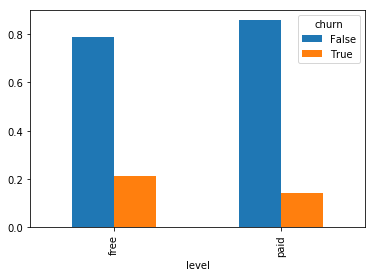

In [47]:
print(df_pd.groupby("level")['churn'].value_counts(normalize=True).unstack())
df_pd.groupby("level")['churn'].value_counts(normalize=True).unstack().plot.bar()

Churn ratio between gender groups. Churn happens more in the male group

churn      False     True 
gender                    
F       0.875998  0.124002
M       0.792063  0.207937


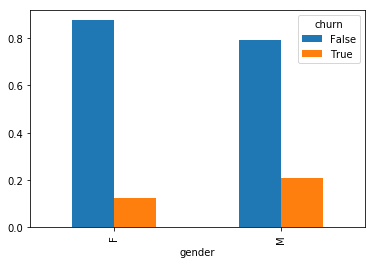

In [48]:
print(df_pd.groupby("gender")['churn'].value_counts(normalize=True).unstack())
df_pd.groupby("gender")['churn'].value_counts(normalize=True).unstack().plot.bar()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Create a function for feature extraction
### Main order of ETL
1. Cleaning 
2. Basic Feature Creation
The order of the extraction of the features is
        1. 'churn'
        2. 'os_system' (from userAgent)
        3. 'location_frist' (from location)
        4. 'total_sessionId' 
        5. 'total_itemInSession' 
        6. 'last_access_time'
        7. 'first_access_time'
        8. 'last_level'
        9. 'time_after_id_creation_hour' 
        10. 'num_week'
        11. 'num_month'
        12. 'num_year'
        13. 'top100_artist_alltime'
        14. 'total_Top100_artist_alltime'
        15. 'top100_song_week'
        16. 'total_Top100_song_week'
        
3. Join Other Dataframes and Do Additioal feature extraction
Other dataframes made from df by using where, groupBy, agg, count methods are
    - 'thumbsup_df',
    - 'thumbsdown_df'
    -  'advert_df'
    - 'addfriend_df'
    - 'addplaylist_df'
    - 'sub_upgrade_df'
    - 'sub_downgrade_df'
    - 'error_df'
    - 'logout_df'
    - 'last_level_df'
    - 'spent_time_df'

In [57]:
def create_dataframe_forML(df):
    def subfunc_cleaning(df):
        # Remove no id rows
        df = df.filter(df["userId"] != "")
        
        return df
        
    def subfunc_featureCreation(df):
        # Make a list of ids who churned
        churn_id_list = df[df.page == "Cancellation Confirmation"].select("userId").distinct().collect()
        churn_id_list = [x['userId'] for x in churn_id_list]
        create_churn_udf = udf(lambda userid: 1 if userid in churn_id_list else 0, IntegerType())
        df = df.withColumn("churn", create_churn_udf(df.userId))

        # Create new userAgent column
        def create_new_agent(userAgent):
            if userAgent == None:
                computer_os = None
            else:
                computer_os = userAgent.split()[1]
                computer_os = re.sub(r'[\W\s]','' ,computer_os)

            return  computer_os
        create_new_agent_udf = udf(create_new_agent, StringType())
        df = df.withColumn("os_system", create_new_agent_udf(df.userAgent))

        # Create new location column
        def create_new_location(location):
            if location == None:
                location_first = None
            else:
                location_first = location.split(',')[-1].split('-')[0].strip()

            return location_first

        create_new_location_udf = udf(create_new_location, StringType())
        df = df.withColumn("location_first", create_new_location_udf(df.location))

        # Create total number of sessionId column
        w = Window.partitionBy(df.userId)
        df = df.withColumn('total_sessionId', size(collect_set('sessionId').over(w)))

        # Create total number of itemInSession column
        df = df.withColumn('total_itemInSession', count('itemInSession').over(w))


      

        # Create last_access_time,first_access_time columns
        df = df.withColumn('last_access_time', max('ts').over(w))
        df = df.withColumn('first_access_time', min('ts').over(w))

        # Create last_level column
        df = df.withColumn('last_level',when(df.last_access_time == df.ts, df.level))


        # Create time difference column
        def calculate_time_after_id_creation(last_time, first_time):
            last_access_datetime = datetime.utcfromtimestamp(last_time / 1000)
            first_access_datetime = datetime.utcfromtimestamp(first_time / 1000)
            time_after_id_creation = last_access_datetime - first_access_datetime
            result = time_after_id_creation.total_seconds()/3600

            return result

        calculate_time_after_id_creation_udf = udf(calculate_time_after_id_creation, FloatType())
        df = df.withColumn("time_after_id_creation(hour)", calculate_time_after_id_creation_udf(df.last_access_time, df.first_access_time))
        df = df.withColumn("time_after_id_creation(hour)", round(col('time_after_id_creation(hour)')/1, 2))


        # convert timestamp to date (string)
        def create_numWeek(ts):
            return datetime.utcfromtimestamp(ts / 1000).strftime("%V")
        def create_numMonth(ts):
            return datetime.utcfromtimestamp(ts / 1000).strftime("%m")
        def create_numYear(ts):
            return datetime.utcfromtimestamp(ts / 1000).strftime("%Y")

        create_numWeek_udf = udf(create_numWeek, StringType())
        create_numMonth_udf = udf(create_numMonth, StringType())
        create_numYear_udf = udf(create_numYear, StringType())
        df = df.withColumn('num_week', create_numWeek_udf(col('ts')))
        df = df.withColumn('num_month', create_numMonth_udf(col('ts')))
        df = df.withColumn('num_year', create_numYear_udf(col('ts')))

        # Make a top_100 alltime artist list
        tmp_list = df.where(df.artist != "").groupby("artist").count().sort(col("count").desc()).collect()[0:100]
        top_100_alltime_artist_list = [row["artist"] for row in tmp_list]
        top_100_alltime_artist_list

        # Make udf to set 1 at churn column in every row of the chrun users 
        def create_top100_alltime(artist):
            if artist in top_100_alltime_artist_list:
                return 1
            else:
                return 0

        create_top100_alltime_udf = udf(create_top100_alltime, IntegerType())
        df = df.withColumn("top100_artist_alltime", create_top100_alltime_udf(df.artist))
        # Count total number of top 100
        w = Window.partitionBy(df.userId)
        df = df.withColumn('total_Top100_artist_alltime', sum('top100_artist_alltime').over(w))

        # Make a dictionary of a best seller song list of each week
        tmp_list = df.select("num_week").distinct().sort("num_week").collect()
        available_week_list = [row["num_week"] for row in tmp_list]
        available_week_list


    # Make a dictionary of a best seller song list of each week

        def create_dict_top100_song_week(available_week_list):
            dict_top100_song_week = dict()
            for week in available_week_list:
                top_100_week_song_list = df.where((df.artist != "") & (df.num_week == week)).groupby("song","num_week").count()\
                .sort(col("num_week"), col("count").desc()).collect()[0:100]
                top_100_week_song_list = [row['song'] for row in top_100_week_song_list]
                dict_top100_song_week[week] = top_100_week_song_list

            return dict_top100_song_week

        dict_top100_song_week = create_dict_top100_song_week(available_week_list)

        # Make a top_100_song_week list
        def create_top100_song_week(song, num_week):
            if song in dict_top100_song_week[num_week]:
                return 1
            else:
                return 0

        create_top100_song_week_udf = udf(create_top100_song_week, IntegerType())
        df = df.withColumn("top100_song_week", create_top100_song_week_udf(df.song, df.num_week))
        # Count total number of top 100_song_week
        w = Window.partitionBy(df.userId)
        df = df.withColumn('total_Top100_song_week', sum('top100_song_week').over(w))
        
        
        return df
    


    def subfunc_joinDf_featureExtraction(df):
        # Create other dataframes to be joined to df dataframe to get 
        # Number of thumb up/ thumb down/ advert/ add friend/ upgrade/ downgrade/ error/ logout
        thumbsup_df = df.where(df.page == 'Thumbs Up').groupBy("userId").agg(count("page").alias("total_thumbsup"))
        thumbsdown_df = df.where(df.page == 'Thumbs Down').groupBy("userId").agg(count("page").alias("total_thumbsdown"))
        advert_df =  df.where(df.page == 'Roll Advert').groupBy("userId").agg(count("page").alias("total_rolladvert"))
        addfriend_df =  df.where(df.page == 'Add Friend').groupBy("userId").agg(count("page").alias("total_addfriend"))
        addplaylist_df =  df.where(df.page == 'Add to Playlist').groupBy("userId").agg(count("page").alias("total_addplaylist"))
        sub_upgrade_df = df.where(df.page == 'Submit Upgrade').groupBy("userId").agg(count("page").alias("total_sub_upgrade"))
        sub_downgrade_df = df.where(df.page == 'Submit Downgrade').groupBy("userId").agg(count("page").alias("total_sub_downgrade"))
        error_df = df.where(df.page == 'Error').groupBy("userId").agg(count("page").alias("total_error"))
        logout_df = df.where(df.page == 'Logout').groupBy("userId").agg(count("page").alias("total_logout"))
        last_level_df = df[df.last_level != 'None'].select("userId","last_level")
        
        # Create total spent time
        spent_time_df = df.groupBy("userId", "sessionId").agg(max('ts').alias("max_ts_session"), 
                                                              min('ts').alias("min_ts_session")).orderBy("sessionId", ascending=True)
        def calculate_time_inSession(max_ts_session, min_ts_session):
            max_ts_session_datetime = datetime.utcfromtimestamp(max_ts_session / 1000)
            min_ts_session_datetime = datetime.utcfromtimestamp(min_ts_session / 1000)
            spent_time_session = max_ts_session_datetime - min_ts_session_datetime
            result = spent_time_session.total_seconds()/3600

            return result

        calculate_time_inSession_udf = udf(calculate_time_inSession, FloatType())
        spent_time_df = spent_time_df.withColumn("time_spent_Session_hour", 
                                                     calculate_time_inSession_udf(spent_time_df.max_ts_session, spent_time_df.min_ts_session))

        w = Window.partitionBy(spent_time_df.userId)
        spent_time_df = spent_time_df.withColumn("time_spent_Total_hour", sum(spent_time_df.time_spent_Session_hour).over(w))
        spent_time_df = spent_time_df.drop('max_ts_session','min_ts_session')
        spent_time_df = spent_time_df.withColumn('time_spent_Session_hour', round(col('time_spent_Session_hour')/1, 2))
        spent_time_df = spent_time_df.withColumn('time_spent_Total_hour', round(col('time_spent_Total_hour')/1, 2))
        spent_time_df_only_total = spent_time_df.drop('time_spent_Session_hour','sessionId').distinct()
        
        # Make df_new for machine learning
        df_new = df.select("userId",'gender', 'churn', 'os_system', 'location_first', 'total_sessionId', 'total_itemInSession',"time_after_id_creation(hour)", 
                           "total_Top100_artist_alltime", "total_Top100_song_week").dropna().drop_duplicates()
        df_new = df_new.join(thumbsup_df, 'userId', how='left').distinct()
        df_new = df_new.join(thumbsdown_df, 'userId', how='left').distinct()
        df_new = df_new.join(advert_df, 'userId', how='left').distinct()
        df_new = df_new.join(addfriend_df, 'userId', how='left').distinct()
        df_new = df_new.join(addplaylist_df, 'userId', how='left').distinct()
        df_new = df_new.join(sub_upgrade_df, 'userId', how='left').distinct()
        df_new = df_new.join(sub_downgrade_df, 'userId', how='left').distinct()
        df_new = df_new.join(error_df, 'userId', how='left').distinct()
        df_new = df_new.join(logout_df, 'userId', how='left').distinct()
        df_new = df_new.fillna(0, subset=['total_thumbsup','total_thumbsdown', 'total_rolladvert', 'total_addfriend', 'total_addplaylist', 'total_sub_upgrade', 
                                         'total_sub_downgrade', 'total_error', 'total_logout'])
        df_new = df_new.join(last_level_df, 'userId', how='left').distinct()
        df_new = df_new.join(spent_time_df_only_total, 'userId', how='left').distinct()
        
        df_new1 = df_new.withColumn("time_spent_Total_day", round(col('time_spent_Total_hour')/24, 2))
        df_new1 = df_new1.withColumn("time_after_id_creation(day)", round(col('time_after_id_creation(hour)')/24, 2))
        df_new1 = df_new1.withColumn("avg_total_sessionId_afterCreation", round(col('total_sessionId') / col('time_after_id_creation(day)'), 2))
        df_new1 = df_new1.withColumn("avg_itemInSession_afterCreation", round(col('total_itemInSession')/col('time_after_id_creation(day)'), 2))
        df_new1 = df_new1.withColumn("avg_thumbsup_afterCreation", round(col('total_thumbsup')/col('time_after_id_creation(day)'), 2))
        df_new1 = df_new1.withColumn("avg_thumbsdown_afterCreation", round((col('total_thumbsdown')/col('time_after_id_creation(day)')), 2))
        df_new1 = df_new1.withColumn("avg_rolladvert_afterCreation", round((col('total_rolladvert')/col('time_after_id_creation(day)')), 2))
        df_new1 = df_new1.withColumn("avg_addfriend_afterCreation", round((col('total_addfriend')/col('time_after_id_creation(day)')), 2))
        df_new1 = df_new1.withColumn("avg_addplaylist_afterCreation", round((col('total_addplaylist')/col('time_after_id_creation(day)')), 2))
        df_new1 = df_new1.withColumn("avg_error_afterCreation", round((col('total_error')/col('time_after_id_creation(day)')), 2))
        df_new1 = df_new1.withColumn("avg_logout_afterCreation", round((col('total_logout')/col('time_after_id_creation(day)')), 2))
        df_new1 = df_new1.withColumn("avg_total_Top100_artist_alltime", round((col('total_Top100_artist_alltime')/col('time_after_id_creation(day)')), 2))
        df_new1 = df_new1.withColumn("avg_total_Top100_song_week", round((col('total_Top100_song_week')/col('time_after_id_creation(day)')), 2))

        
        return df_new1
    
    df = subfunc_cleaning(df)
    print("Cleaning is done")
    df = subfunc_featureCreation(df)
    print("Feature creation is done")
    df_new1 = subfunc_joinDf_featureExtraction(df)
    print("Joining dataframes and feature extraction are done")
    
    return df_new1

df = spark.read.options(header=True).json("mini_sparkify_event_data.json")
df_ML = create_dataframe_forML(df)
df_ML.cache()
df_ML.take(1)

Cleaning is done
Feature creation is done
Joining dataframes and feature extraction are done


[Row(userId='100010', gender='F', churn=0, os_system='iPhone', location_first='CT', total_sessionId=7, total_itemInSession=381, time_after_id_creation(hour)=1061.23, total_Top100_artist_alltime=61, total_Top100_song_week=31, total_thumbsup=17, total_thumbsdown=5, total_rolladvert=52, total_addfriend=4, total_addplaylist=7, total_sub_upgrade=0, total_sub_downgrade=0, total_error=0, total_logout=5, last_level='free', time_spent_Total_hour=18.02, time_spent_Total_day=0.75, time_after_id_creation(day)=44.22, avg_total_sessionId_afterCreation=0.16, avg_itemInSession_afterCreation=8.62, avg_thumbsup_afterCreation=0.38, avg_thumbsdown_afterCreation=0.11, avg_rolladvert_afterCreation=1.18, avg_addfriend_afterCreation=0.09, avg_addplaylist_afterCreation=0.16, avg_error_afterCreation=0.0, avg_logout_afterCreation=0.11, avg_total_Top100_artist_alltime=1.38, avg_total_Top100_song_week=0.7)]

In [58]:
df_ML.count()

225

In [59]:
df_ML.head(1)

[Row(userId='100010', gender='F', churn=0, os_system='iPhone', location_first='CT', total_sessionId=7, total_itemInSession=381, time_after_id_creation(hour)=1061.23, total_Top100_artist_alltime=61, total_Top100_song_week=31, total_thumbsup=17, total_thumbsdown=5, total_rolladvert=52, total_addfriend=4, total_addplaylist=7, total_sub_upgrade=0, total_sub_downgrade=0, total_error=0, total_logout=5, last_level='free', time_spent_Total_hour=18.02, time_spent_Total_day=0.75, time_after_id_creation(day)=44.22, avg_total_sessionId_afterCreation=0.16, avg_itemInSession_afterCreation=8.62, avg_thumbsup_afterCreation=0.38, avg_thumbsdown_afterCreation=0.11, avg_rolladvert_afterCreation=1.18, avg_addfriend_afterCreation=0.09, avg_addplaylist_afterCreation=0.16, avg_error_afterCreation=0.0, avg_logout_afterCreation=0.11, avg_total_Top100_artist_alltime=1.38, avg_total_Top100_song_week=0.7)]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Make train, test and validation sets 

In [60]:
### Make train, test and validation sets 
train, test, validation = df_ML.randomSplit([0.7, 0.15, 0.15], seed = 44)

In [61]:
print(train.count())
print(test.count())
print(validation.count())

156
38
31


In [62]:
df_ML.head(1)

[Row(userId='100010', gender='F', churn=0, os_system='iPhone', location_first='CT', total_sessionId=7, total_itemInSession=381, time_after_id_creation(hour)=1061.23, total_Top100_artist_alltime=61, total_Top100_song_week=31, total_thumbsup=17, total_thumbsdown=5, total_rolladvert=52, total_addfriend=4, total_addplaylist=7, total_sub_upgrade=0, total_sub_downgrade=0, total_error=0, total_logout=5, last_level='free', time_spent_Total_hour=18.02, time_spent_Total_day=0.75, time_after_id_creation(day)=44.22, avg_total_sessionId_afterCreation=0.16, avg_itemInSession_afterCreation=8.62, avg_thumbsup_afterCreation=0.38, avg_thumbsdown_afterCreation=0.11, avg_rolladvert_afterCreation=1.18, avg_addfriend_afterCreation=0.09, avg_addplaylist_afterCreation=0.16, avg_error_afterCreation=0.0, avg_logout_afterCreation=0.11, avg_total_Top100_artist_alltime=1.38, avg_total_Top100_song_week=0.7)]

### Make Pipelines to feed data into classifiers

In [63]:
column_for_stringindexer_list = ["gender", 'last_level', 'location_first']
indexers = [StringIndexer(inputCol=column, outputCol="indexed_"+column) for column in column_for_stringindexer_list]
encoder = OneHotEncoderEstimator(inputCols=["indexed_gender", "indexed_last_level", "indexed_location_first"],
                                       outputCols=["gender_feat", "last_level_feat", "location_feat"],
                                handleInvalid = 'keep')
features = ['gender_feat', 'last_level_feat', 'location_feat', 'time_after_id_creation(day)','avg_total_sessionId_afterCreation','avg_itemInSession_afterCreation',
            'avg_thumbsup_afterCreation','avg_thumbsdown_afterCreation','avg_rolladvert_afterCreation','avg_addfriend_afterCreation',
            'avg_addplaylist_afterCreation','avg_error_afterCreation','avg_logout_afterCreation','avg_total_Top100_artist_alltime','avg_total_Top100_song_week']
assembler = VectorAssembler(inputCols=features, outputCol="scaled_features")


pipeline = Pipeline(stages=[indexers[0], indexers[1], indexers[2], encoder, assembler])
df_ML1 = pipeline.fit(df_ML).transform(df_ML)
df_ML1.head()

Row(userId='100010', gender='F', churn=0, os_system='iPhone', location_first='CT', total_sessionId=7, total_itemInSession=381, time_after_id_creation(hour)=1061.23, total_Top100_artist_alltime=61, total_Top100_song_week=31, total_thumbsup=17, total_thumbsdown=5, total_rolladvert=52, total_addfriend=4, total_addplaylist=7, total_sub_upgrade=0, total_sub_downgrade=0, total_error=0, total_logout=5, last_level='free', time_spent_Total_hour=18.02, time_spent_Total_day=0.75, time_after_id_creation(day)=44.22, avg_total_sessionId_afterCreation=0.16, avg_itemInSession_afterCreation=8.62, avg_thumbsup_afterCreation=0.38, avg_thumbsdown_afterCreation=0.11, avg_rolladvert_afterCreation=1.18, avg_addfriend_afterCreation=0.09, avg_addplaylist_afterCreation=0.16, avg_error_afterCreation=0.0, avg_logout_afterCreation=0.11, avg_total_Top100_artist_alltime=1.38, avg_total_Top100_song_week=0.7, indexed_gender=1.0, indexed_last_level=1.0, indexed_location_first=9.0, gender_feat=SparseVector(2, {1: 1.0}),

In [64]:
df_ML1_togo = df_ML1.select(col("churn").alias("label"), col("scaled_features").alias("features"))
df_ML1_togo.head(1)

[Row(label=0, features=SparseVector(57, {1: 1.0, 3: 1.0, 13: 1.0, 45: 44.22, 46: 0.16, 47: 8.62, 48: 0.38, 49: 0.11, 50: 1.18, 51: 0.09, 52: 0.16, 54: 0.11, 55: 1.38, 56: 0.7}))]

In [65]:
### Make train, test and validation sets 
train, test, validation = df_ML1_togo.randomSplit([0.7, 0.15, 0.15], seed = 41)

In [66]:
# initialize random forest classifier
rf = RandomForestClassifier(featuresCol="features",labelCol="label")
# initialize logistic regression
lr = LogisticRegression(maxIter=5,threshold=0.3)
# initialize logistic regression
l_SVC = LinearSVC(featuresCol="features",labelCol="label",threshold=0.4)
# initialize Naive Bayes
nb = NaiveBayes(featuresCol="features",labelCol="label")
# initialize N GBTClassifier
gbt = GBTClassifier(featuresCol="features",labelCol="label", maxIter=5)

In [67]:
# random forest
##
starttime = datetime.now()
model_rf = rf.fit(train)
pred_train_rf = model_rf.transform(train)
pred_test_rf = model_rf.transform(test)
pred_validation_rf = model_rf.transform(validation)

## train_set
predictionAndLabels_rf = pred_train_rf.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_rf = MulticlassMetrics(predictionAndLabels_rf )
# F1 score
print("F1 score of training set: ", metrics_rf.fMeasure())
print("Precision of training set: ", metrics_rf.precision(1))
print("Recall of training set: " , metrics_rf.recall(1))
print(metrics_rf.confusionMatrix().toArray())
print()

## test_set
predictionAndLabels_rf = pred_test_rf.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_rf = MulticlassMetrics(predictionAndLabels_rf)
# F1 score
print("F1 score of test set: ", metrics_rf.fMeasure())
print("Precision of test set: ", metrics_rf.precision(1))
print("Recall of test set: " , metrics_rf.recall(1))
print(metrics_rf.confusionMatrix().toArray())
print(datetime.now() - starttime)
print()

## validation_set
predictionAndLabels_rf = pred_validation_rf.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_rf = MulticlassMetrics(predictionAndLabels_rf)
# F1 score
print("F1 score of validation set: ", metrics_rf.fMeasure())
print("Precision of validation set: ", metrics_rf.precision(1))
print("Recall of validation set: ", metrics_rf.recall(1))
print(metrics_rf.confusionMatrix().toArray())
print(datetime.now() - starttime)

F1 score of training set:  0.8910256410256411
Precision of training set:  0.9230769230769231
Recall of training set:  0.6153846153846154
[[115.   2.]
 [ 15.  24.]]

F1 score of test set:  0.8333333333333334
Precision of test set:  1.0
Recall of test set:  0.3333333333333333
[[27.  0.]
 [ 6.  3.]]
0:01:01.387178

F1 score of validation set:  0.8484848484848485
Precision of validation set:  0.3333333333333333
Recall of validation set:  0.25
[[27.  2.]
 [ 3.  1.]]
0:01:17.595099


In [68]:
# Logistic regression
##
starttime = datetime.now()
model_lr = lr.fit(train)
pred_train_lr = model_lr.transform(train)
pred_test_lr = model_lr.transform(test)
pred_validation_lr = model_lr.transform(validation)

## train_set
predictionAndLabels_lr = pred_train_lr.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_lr = MulticlassMetrics(predictionAndLabels_lr)

# F1 score
print("F1 score of training set: ", metrics_lr.fMeasure())
print("Precision of training set: ", metrics_lr.precision(1))
print("Recall of training set: " , metrics_lr.recall(1))
print(metrics_lr.confusionMatrix().toArray())
print()

## test_set
predictionAndLabels_lr = pred_test_lr.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_lr = MulticlassMetrics(predictionAndLabels_lr)
# F1 score
print("F1 score of test set: ", metrics_lr.fMeasure())
print("Precision of test set: ", metrics_lr.precision(1))
print("Recall of test set: ", metrics_lr.recall(1))
print(metrics_lr.confusionMatrix().toArray())
print(datetime.now() - starttime)
print()

## validation_set
predictionAndLabels_lr = pred_validation_lr.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_lr = MulticlassMetrics(predictionAndLabels_lr)
# F1 score
print("F1 score of validation set: " , metrics_lr.fMeasure())
print("Precision of validation set:  " , metrics_lr.precision(1))
print("Recall on validation set: ", metrics_lr.recall(1))
print(metrics_lr.confusionMatrix().toArray())
print(datetime.now() - starttime)

F1 score of training set:  0.8846153846153846
Precision of training set:  0.7333333333333333
Recall of training set:  0.8461538461538461
[[105.  12.]
 [  6.  33.]]

F1 score of test set:  0.6388888888888888
Precision of test set:  0.3333333333333333
Recall of test set:  0.4444444444444444
[[19.  8.]
 [ 5.  4.]]
0:00:45.139530

F1 score of validation set:  0.7575757575757576
Precision of validation set:   0.16666666666666666
Recall on validation set:  0.25
[[24.  5.]
 [ 3.  1.]]
0:00:58.570222


In [69]:
# Linear SVC
##
starttime = datetime.now()
model_l_SVC = l_SVC.fit(train)
pred_train_l_SVC = model_l_SVC.transform(train)
pred_test_l_SVC = model_l_SVC.transform(test)

## train_set
predictionAndLabels_l_SVC = pred_train_l_SVC.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_l_SVC = MulticlassMetrics(predictionAndLabels_l_SVC)

# F1 score
print("F1 score on training dataset is %s" % metrics_l_SVC.fMeasure())
print("Precision on training dataset is %s" % metrics_l_SVC.precision(1))
print("Recall on training dataset is %s" % metrics_l_SVC.recall(1))
print(metrics_l_SVC.confusionMatrix().toArray())
print()

## test_set
predictionAndLabels_l_SVC = pred_test_l_SVC.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_l_SVC = MulticlassMetrics(predictionAndLabels_l_SVC)
# F1 score
print("F1 score on test dataset is %s" % metrics_l_SVC.fMeasure())
print("Precision on test dataset is %s" % metrics_l_SVC.precision(1))
print("Recall on test dataset is %s" % metrics_l_SVC.recall(1))
print(metrics_l_SVC.confusionMatrix().toArray())
print(datetime.now() - starttime)

F1 score on training dataset is 0.8910256410256411
Precision on training dataset is 0.8928571428571429
Recall on training dataset is 0.6410256410256411
[[114.   3.]
 [ 14.  25.]]

F1 score on test dataset is 0.75
Precision on test dataset is 0.5
Recall on test dataset is 0.3333333333333333
[[24.  3.]
 [ 6.  3.]]
0:07:15.118451


In [70]:
# Naive Bayes
##
starttime = datetime.now()
model_nb = nb.fit(train)
pred_train_nb = model_nb.transform(train)
pred_test_nb = model_nb.transform(test)

## train_set
predictionAndLabels_nb = pred_train_nb.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_nb = MulticlassMetrics(predictionAndLabels_nb)

# F1 score
print("F1 score of training set: " , metrics_nb.fMeasure())
print("Precision of training set: " , metrics_nb.precision(1))
print("Recall of training set: " , metrics_nb.recall(1))
print(metrics_nb.confusionMatrix().toArray())
print()

## test_set
predictionAndLabels_nb = pred_test_nb.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_nb = MulticlassMetrics(predictionAndLabels_nb)
# F1 score
print("F1 score of test set: " , metrics_nb.fMeasure())
print("Precision of test set: " , metrics_nb.precision(1))
print("Recall of test set: " , metrics_nb.recall(1))
print(metrics_nb.confusionMatrix().toArray())
print(datetime.now() - starttime)

F1 score of training set:  0.8012820512820513
Precision of training set:  0.7
Recall of training set:  0.358974358974359
[[111.   6.]
 [ 25.  14.]]

F1 score of test set:  0.7777777777777778
Precision of test set:  0.5714285714285714
Recall of test set:  0.4444444444444444
[[24.  3.]
 [ 5.  4.]]
0:00:32.237172


In [71]:
# GBT
##
starttime = datetime.now()
model_gbt = gbt.fit(train)
pred_train_gbt = model_gbt.transform(train)
pred_test_gbt = model_gbt.transform(test)
pred_validation_gbt = model_gbt.transform(validation)

## train_set
predictionAndLabels_gbt = pred_train_gbt.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_gbt = MulticlassMetrics(predictionAndLabels_gbt)

# F1 score
print("F1 score of training set: ", metrics_gbt.fMeasure())
print("Precision of training set: ", metrics_gbt.precision(1))
print("Recall of training set: ", metrics_gbt.recall(1))
print(metrics_gbt.confusionMatrix().toArray())
print()

## test_set
predictionAndLabels_gbt = pred_test_gbt.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_gbt = MulticlassMetrics(predictionAndLabels_gbt)
# F1 score
print("F1 score of test set: ", metrics_gbt.fMeasure())
print("Precision of test set: " , metrics_gbt.precision(1))
print("Recall of test set: " , metrics_gbt.recall(1))
print(metrics_gbt.confusionMatrix().toArray())
print(datetime.now() - starttime)
print()

## valid_set
predictionAndLabels_gbt = pred_validation_gbt.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_gbt = MulticlassMetrics(predictionAndLabels_gbt)
# F1 score
print("F1 score of validation set: ", metrics_gbt.fMeasure())
print("Precision of validation set: ", metrics_gbt.precision(1))
print("Recall of validation set: ", metrics_gbt.recall(1))
print(metrics_gbt.confusionMatrix().toArray())
print(datetime.now() - starttime)

F1 score of training set:  1.0
Precision of training set:  1.0
Recall of training set:  1.0
[[117.   0.]
 [  0.  39.]]

F1 score of test set:  0.8055555555555556
Precision of test set:  0.5833333333333334
Recall of test set:  0.7777777777777778
[[22.  5.]
 [ 2.  7.]]
0:01:33.846464

F1 score of validation set:  0.9090909090909091
Precision of validation set:  0.6666666666666666
Recall of validation set:  0.5
[[28.  1.]
 [ 2.  2.]]
0:01:49.266929


According to the results above, only 3 classifiers including `Random Forest`, `Logistic Regression`, and `GBT classifier` passed to the final steps. The reasons of disqualification of the rest two models are that LinearSVC was too slow and Naive Bayes did not have good F1 score. Logistic Regression did not show good F1 score, but I passed it to the final steps because the model has threshold parameter that I expecedt that it might help to increase precision and recall values.


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

### Pipelines after MinMax Scaler

In [72]:
column_for_stringindexer_list = ["gender", 'last_level', 'location_first']
indexers = [StringIndexer(inputCol=column, outputCol="indexed_"+column) for column in column_for_stringindexer_list]
encoder = OneHotEncoderEstimator(inputCols=["indexed_gender", "indexed_last_level", "indexed_location_first"],
                                       outputCols=["gender_feat", "last_level_feat", "location_feat"],
                                handleInvalid = 'keep')
features = ['gender_feat', 'last_level_feat', 'location_feat', 'time_after_id_creation(day)','avg_total_sessionId_afterCreation','avg_itemInSession_afterCreation',
            'avg_thumbsup_afterCreation','avg_thumbsdown_afterCreation','avg_rolladvert_afterCreation','avg_addfriend_afterCreation',
            'avg_addplaylist_afterCreation','avg_error_afterCreation','avg_logout_afterCreation','avg_total_Top100_artist_alltime','avg_total_Top100_song_week']
assembler = VectorAssembler(inputCols=features, outputCol="scaled_features")
scaler = MinMaxScaler(inputCol="scaled_features" , outputCol="ScaledFeatures")


pipeline = Pipeline(stages=[indexers[0], indexers[1], indexers[2], encoder, assembler, scaler])
df_ML2= pipeline.fit(df_ML).transform(df_ML)
df_ML2.head()

Row(userId='100010', gender='F', churn=0, os_system='iPhone', location_first='CT', total_sessionId=7, total_itemInSession=381, time_after_id_creation(hour)=1061.23, total_Top100_artist_alltime=61, total_Top100_song_week=31, total_thumbsup=17, total_thumbsdown=5, total_rolladvert=52, total_addfriend=4, total_addplaylist=7, total_sub_upgrade=0, total_sub_downgrade=0, total_error=0, total_logout=5, last_level='free', time_spent_Total_hour=18.02, time_spent_Total_day=0.75, time_after_id_creation(day)=44.22, avg_total_sessionId_afterCreation=0.16, avg_itemInSession_afterCreation=8.62, avg_thumbsup_afterCreation=0.38, avg_thumbsdown_afterCreation=0.11, avg_rolladvert_afterCreation=1.18, avg_addfriend_afterCreation=0.09, avg_addplaylist_afterCreation=0.16, avg_error_afterCreation=0.0, avg_logout_afterCreation=0.11, avg_total_Top100_artist_alltime=1.38, avg_total_Top100_song_week=0.7, indexed_gender=1.0, indexed_last_level=1.0, indexed_location_first=9.0, gender_feat=SparseVector(2, {1: 1.0}),

In [73]:
df_ML2_togo = df_ML2.select(col("churn").alias("label"), col("scaled_features").alias("features"))
df_ML2_togo.head(1)

[Row(label=0, features=SparseVector(57, {1: 1.0, 3: 1.0, 13: 1.0, 45: 44.22, 46: 0.16, 47: 8.62, 48: 0.38, 49: 0.11, 50: 1.18, 51: 0.09, 52: 0.16, 54: 0.11, 55: 1.38, 56: 0.7}))]

In [74]:
### Make train, test and validation sets 
train, test, validation = df_ML2_togo.randomSplit([0.7, 0.15, 0.15], seed = 41)

In [75]:
# initialize random forest classifier
rf = RandomForestClassifier(featuresCol="features",labelCol="label")
# initialize logistic regression
lr = LogisticRegression(maxIter=5,threshold=0.3)
# initialize N GBTClassifier
gbt = GBTClassifier(featuresCol="features",labelCol="label", maxIter=5)

In [76]:
# random forest
##
starttime = datetime.now()
model_rf = rf.fit(train)
pred_train_rf = model_rf.transform(train)
pred_test_rf = model_rf.transform(test)
pred_validation_rf = model_rf.transform(validation)

## train_set
predictionAndLabels_rf = pred_train_rf.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_rf = MulticlassMetrics(predictionAndLabels_rf )
# F1 score
print("F1 score of training set: ", metrics_rf.fMeasure())
print("Precision of training set: ", metrics_rf.precision(1))
print("Recall of training set: " , metrics_rf.recall(1))
print(metrics_rf.confusionMatrix().toArray())
print()

## test_set
predictionAndLabels_rf = pred_test_rf.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_rf = MulticlassMetrics(predictionAndLabels_rf)
# F1 score
print("F1 score of test set: ", metrics_rf.fMeasure())
print("Precision of test set: ", metrics_rf.precision(1))
print("Recall of test set: " , metrics_rf.recall(1))
print(metrics_rf.confusionMatrix().toArray())
print(datetime.now() - starttime)
print()

## validation_set
predictionAndLabels_rf = pred_validation_rf.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_rf = MulticlassMetrics(predictionAndLabels_rf)
# F1 score
print("F1 score of validation set: ", metrics_rf.fMeasure())
print("Precision of validation set: ", metrics_rf.precision(1))
print("Recall of validation set: ", metrics_rf.recall(1))
print(metrics_rf.confusionMatrix().toArray())
print(datetime.now() - starttime)

F1 score of training set:  0.8910256410256411
Precision of training set:  0.9230769230769231
Recall of training set:  0.6153846153846154
[[115.   2.]
 [ 15.  24.]]

F1 score of test set:  0.8333333333333334
Precision of test set:  1.0
Recall of test set:  0.3333333333333333
[[27.  0.]
 [ 6.  3.]]
0:00:52.989544

F1 score of validation set:  0.8484848484848485
Precision of validation set:  0.3333333333333333
Recall of validation set:  0.25
[[27.  2.]
 [ 3.  1.]]
0:01:10.622901


In [77]:
# Logistic regression
##
starttime = datetime.now()
model_lr = lr.fit(train)
pred_train_lr = model_lr.transform(train)
pred_test_lr = model_lr.transform(test)
pred_validation_lr = model_lr.transform(validation)

## train_set
predictionAndLabels_lr = pred_train_lr.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_lr = MulticlassMetrics(predictionAndLabels_lr)

# F1 score
print("F1 score of training set: ", metrics_lr.fMeasure())
print("Precision of training set: ", metrics_lr.precision(1))
print("Recall of training set: " , metrics_lr.recall(1))
print(metrics_lr.confusionMatrix().toArray())
print()

## test_set
predictionAndLabels_lr = pred_test_lr.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_lr = MulticlassMetrics(predictionAndLabels_lr)
# F1 score
print("F1 score of test set: ", metrics_lr.fMeasure())
print("Precision of test set: ", metrics_lr.precision(1))
print("Recall of test set: ", metrics_lr.recall(1))
print(metrics_lr.confusionMatrix().toArray())
print(datetime.now() - starttime)
print()

## validation_set
predictionAndLabels_lr = pred_validation_lr.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_lr = MulticlassMetrics(predictionAndLabels_lr)
# F1 score
print("F1 score of validation set: " , metrics_lr.fMeasure())
print("Precision of validation set:  " , metrics_lr.precision(1))
print("Recall on validation set: ", metrics_lr.recall(1))
print(metrics_lr.confusionMatrix().toArray())
print(datetime.now() - starttime)

F1 score of training set:  0.8846153846153846
Precision of training set:  0.7333333333333333
Recall of training set:  0.8461538461538461
[[105.  12.]
 [  6.  33.]]

F1 score of test set:  0.6388888888888888
Precision of test set:  0.3333333333333333
Recall of test set:  0.4444444444444444
[[19.  8.]
 [ 5.  4.]]
0:00:40.646768

F1 score of validation set:  0.7575757575757576
Precision of validation set:   0.16666666666666666
Recall on validation set:  0.25
[[24.  5.]
 [ 3.  1.]]
0:00:55.012805


In [78]:
# GBT
##
starttime = datetime.now()
model_gbt = gbt.fit(train)
pred_train_gbt = model_gbt.transform(train)
pred_test_gbt = model_gbt.transform(test)
pred_validation_gbt = model_gbt.transform(validation)

## train_set
predictionAndLabels_gbt = pred_train_gbt.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_gbt = MulticlassMetrics(predictionAndLabels_gbt)

# F1 score
print("F1 score of training set: ", metrics_gbt.fMeasure())
print("Precision of training set: ", metrics_gbt.precision(1))
print("Recall of training set: ", metrics_gbt.recall(1))
print(metrics_gbt.confusionMatrix().toArray())
print()

## test_set
predictionAndLabels_gbt = pred_test_gbt.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_gbt = MulticlassMetrics(predictionAndLabels_gbt)
# F1 score
print("F1 score of test set: ", metrics_gbt.fMeasure())
print("Precision of test set: " , metrics_gbt.precision(1))
print("Recall of test set: " , metrics_gbt.recall(1))
print(metrics_gbt.confusionMatrix().toArray())
print(datetime.now() - starttime)
print()

## valid_set
predictionAndLabels_gbt = pred_validation_gbt.rdd.map(lambda x: (float(x.prediction), float(x.label)))
# Instantiate metrics object
metrics_gbt = MulticlassMetrics(predictionAndLabels_gbt)
# F1 score
print("F1 score of validation set: ", metrics_gbt.fMeasure())
print("Precision of validation set: ", metrics_gbt.precision(1))
print("Recall of validation set: ", metrics_gbt.recall(1))
print(metrics_gbt.confusionMatrix().toArray())
print(datetime.now() - starttime)

F1 score of training set:  1.0
Precision of training set:  1.0
Recall of training set:  1.0
[[117.   0.]
 [  0.  39.]]

F1 score of test set:  0.8055555555555556
Precision of test set:  0.5833333333333334
Recall of test set:  0.7777777777777778
[[22.  5.]
 [ 2.  7.]]
0:01:30.994563

F1 score of validation set:  0.9090909090909091
Precision of validation set:  0.6666666666666666
Recall of validation set:  0.5
[[28.  1.]
 [ 2.  2.]]
0:01:45.296827


# Conclusion

Here, I chose `GBTclassifier` as the final model for this Sparkify project. 

To select the best model, I considered two metrics F1 score and recall. `Logistic Regression` was not qualified because I tested  several times with different thresholds, it could not show a good F1 score compared to other two. In terms of `F1 score`, `Random Forest Classifier` showed a good F1 score, a good precision, but a bad recall.  The main goal of this project is to predict Sparkify users who are going to churn for `Sparkify`. With a expected churn list, Sparkify will do something to prevent the users from churning. 


**So, it is meaningful to scarifice some F1 score and get higher recall for Sparkify because the company could do some promotions on the user who are reallly going to churn.** If I selected  `Random Forest Classifier` as my prediction model, the majority of the real churn users would not be predicted by the model.